# Singapore housing analysis

## Author: Ankur Shanker

## Student ID: 21159916

### **Section 1:** Importing packages necessary for workbook exectuion.

Libraries necessary for workbook execution related to functionality responsible for geo-spatial data reading, plotting, and statistical analysis need to be imported in order for this workbook to function.

In [1]:
# Import packages required for analysis
import pandas as pd
from sklearn.model_selection import train_test_split
import rfpimp
from sklearn import model_selection

# Import packages required for numeric operations
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

In [2]:
# Import packages required for geospatial analysis
import geopandas as gpd
import pyproj
import geopy.distance
pyproj.datadir.get_data_dir()

'C:\\Users\\ankur\\AppData\\Roaming\\jupyterlab-desktop\\jlab_server\\Library\\share\\proj'

In [4]:
# Import packages required for data visualisation
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn
sn.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

### **Section 2:** Reading and formatting data

Data related to the housing industry of Dubai (courtsey of Knight Frank) is read in and interepreated below.

In [5]:
singapore_2000_onwards = pd.read_csv('Data/Singapore data/Singapore housing.csv')
singapore_2000_onwards = gpd.GeoDataFrame(singapore_2000_onwards.loc[:, [x for x in singapore_2000_onwards.columns if x !="geometry"]],
geometry=gpd.GeoSeries.from_wkt(singapore_2000_onwards["geometry"])
)

In [6]:
singapore_2000_onwards = singapore_2000_onwards[['mean_resale_price',
       'Closest distance to Marina Bay Sands',
       'Closest distance to Resorts World Casino Sentosa', 'geometry',
       'Closest distance to a hotel', 'Closest distance to a park',
       'Traffic lights within 500 meters', 'Parking lots within 500 meters']]

### **Section 2:** Regression

The final step of the analysis presented in this workbook involves determining the dependent and independent variables that will be utilised in the regression analysis a process that will involve the consideration of Variance Inflation Factors and the nature of the distribution of each independent variable, in order to determine the exsitance or lack thereof a linear relationship.

If a Variance Inflation Factor score is determined to be excessive a variable is removed, likewise the existance of a non-normal frequency distribution will involve the utilisation of a log transformation for an independent variable.

First the columns that exist within the dataframe that is created above can be highlighted as follows.

Following this, dependent and independent variables can be extracted.

In [7]:
dependent_variable = singapore_2000_onwards['mean_resale_price']

In [8]:
independent_variables = singapore_2000_onwards.drop('mean_resale_price', axis=1)
independent_variables.drop('Closest distance to Marina Bay Sands', axis=1, inplace=True)
independent_variables

,Closest distance to Resorts World Casino Sentosa,geometry,Closest distance to a hotel,Closest distance to a park,Traffic lights within 500 meters,Parking lots within 500 meters
0,9.057217e+03,POINT (103.93147 1.32567),1.853188e+03,7.996054e+02,1,0
1,2.915024e+03,POINT (103.83535 1.27935),4.987472e+02,5.739934e+02,0,300
2,2.635760e+05,POINT (101.46708 1.51128),2.536406e+05,2.484460e+05,0,0
3,6.335036e+06,POINT (146.00830 -41.10814),6.332915e+06,6.330579e+06,0,0
4,4.703110e+03,POINT (103.88706 1.31819),4.229202e+02,4.021314e+02,1,412
...,...,...,...,...,...,...
1967,1.131450e+04,POINT (103.93169 1.35824),3.404486e+03,1.427613e+03,0,588
1968,7.787478e+03,POINT (103.88324 1.35147),5.638358e+02,2.796723e+02,0,9
1969,7.787478e+03,POINT (103.88324 1.35147),5.638358e+02,2.796723e+02,0,9
1970,7.787478e+03,POINT (103.88324 1.35147),5.638358e+02,2.796723e+02,0,9


In [9]:
independent_variables.drop('geometry', axis=1, inplace=True)


Columns can now be iteratively dropped based on their Variance Inflation Factor scores in order to prevent further regression analysis from being affected by multicolliearity.

The following function is from Quantitative Methods tutorial 4 (CASA0007) 
It calculates the VIF score of each independent variable and returns a dataframe containing independent variables that have a VIF score that is below 10

Source: https://moodle.ucl.ac.uk/pluginfile.php/3532739/mod_resource/content/6/Practical_advanced_regression_UPDATED.ipynb

In [10]:
def drop_column_using_vif_(df, thresh=10):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF.
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i)
                            for i in range(df_with_const.shape[1])],
                           name="VIF",
                           index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')

        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed.
        # This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns=index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

The utilisation of the above function removes the following variables from subsequent consideration in regression analysis.

In [11]:
independent_variables_vif = drop_column_using_vif_(independent_variables)

Dropping: Closest distance to a hotel
Dropping: Closest distance to Resorts World Casino Sentosa


Finally, ordinary least squares linear regression is performed.

In [12]:
stats = sm.OLS(endog=dependent_variable, exog=independent_variables_vif).fit()
stats.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      mean_resale_price   R-squared (uncentered):                   0.456
Model:                            OLS   Adj. R-squared (uncentered):              0.455
Method:                 Least Squares   F-statistic:                              549.2
Date:                Sat, 20 Aug 2022   Prob (F-statistic):                   2.52e-259
Time:                        12:55:05   Log-Likelihood:                         -27754.
No. Observations:                1972   AIC:                                  5.551e+04
Df Residuals:                    1969   BIC:                                  5.553e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Closest distance to a park           0.0307      0.002     19.754      0.000       0.028       0.034
Traffic lights within 500 meters  2.471e+05   1.09e+04     22.698      0.000    2.26e+05    2.68e+05
Parking lots within 500 meters     887.8846     38.412     23.115      0.000     812.552     963.217
==============================================================================
Omnibus:                       26.523   Durbin-Watson:                   1.199
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.928
Skew:                          -0.220   Prob(JB):                     6.37e-06
Kurtosis:                       2.689   Cond. No.                     7.00e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large,  7e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### **Section 3:** Singapore Housing and Hospitality data visualisation

As both Singapore's housing and hospitality industries have been utilised in the housing regression model both will be visualised in this workbook (removing the need to visualise the hospitality industry again in the other workbook).

Developing an understanding of how Singapore' house prices vary by geospatial boundary, where potential concentrations of these boundaries are located, and their relative distance to hotels and the 'Resorts World' Casino in Sentosa is crucial to developing an understanding of the geospatial relationship that exists between these three cateogries of properties.

The first step involves extracting a geospatial boundary shapefile of singapore.

In [13]:
singapore_map = gpd.read_file('Data/Singapore Data/Geospatial Data/master-plan-2014-subzone-boundary-web-shp/MP14_SUBZONE_WEB_PL.shp')
singapore_map.to_crs({'init': 'epsg:4326'}, inplace=True)

c:\Users\ankur\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


This geospatial shape file can then be merged with the house price data for Singapore.

In [14]:
singapore_property_map = gpd.sjoin(singapore_2000_onwards, singapore_map, how='left', op='within')
singapore_property_map

c:\Users\ankur\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\IPython\core\interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\ankur\AppData\Local\Temp\ipykernel_3756\3392937436.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: +init=epsg:4326 +type=crs

  singapore_property_map = gpd.sjoin(singapore_2000_onwards, singapore_map, how='left', op='within')


,mean_resale_price,Closest distance to Marina Bay Sands,Closest distance to Resorts World Casino Sentosa,geometry,Closest distance to a hotel,Closest distance to a park,Traffic lights within 500 meters,Parking lots within 500 meters,index_right,OBJECTID,...,PLN_AREA_N,PLN_AREA_C,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D,X_ADDR,Y_ADDR,SHAPE_Leng,SHAPE_Area
0,338909.623855,9.057217e+03,9.057217e+03,POINT (103.93147 1.32567),1.853188e+03,7.996054e+02,1,0,198.0,199.0,...,BEDOK,BD,EAST REGION,ER,A2254301F85C1EDF,2014-12-05,39429.2104,34737.6194,8414.962102,3.203663e+06
1,417188.365358,2.915024e+03,2.915024e+03,POINT (103.83535 1.27935),4.987472e+02,5.739934e+02,0,300,31.0,32.0,...,BUKIT MERAH,BM,CENTRAL REGION,CR,91630902E00FD7B9,2014-12-05,28147.2210,29131.0368,2915.282048,5.330174e+05
2,698816.998405,2.635760e+05,2.635760e+05,POINT (101.46708 1.51128),2.536406e+05,2.484460e+05,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,419808.253968,6.335036e+06,6.335036e+06,POINT (146.00830 -41.10814),6.332915e+06,6.330579e+06,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,428180.333312,4.703110e+03,4.703110e+03,POINT (103.88706 1.31819),4.229202e+02,4.021314e+02,1,412,162.0,163.0,...,GEYLANG,GL,CENTRAL REGION,CR,83AFAB768B6B2B66,2014-12-05,33592.5759,32970.8301,7100.699079,2.959368e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967,684870.708333,1.131450e+04,1.131450e+04,POINT (103.93169 1.35824),3.404486e+03,1.427613e+03,0,588,181.0,182.0,...,TAMPINES,TM,EAST REGION,ER,2E3EA3D1BBF9A601,2014-12-05,39421.6571,36739.2069,8058.335660,3.475210e+06
1968,422688.676740,7.787478e+03,7.787478e+03,POINT (103.88324 1.35147),5.638358e+02,2.796723e+02,0,9,230.0,231.0,...,HOUGANG,HG,NORTH-EAST REGION,NER,6EDE1DB873D24BDD,2014-12-05,33930.3169,37657.0260,5438.211022,1.515534e+06
1969,432444.543651,7.787478e+03,7.787478e+03,POINT (103.88324 1.35147),5.638358e+02,2.796723e+02,0,9,230.0,231.0,...,HOUGANG,HG,NORTH-EAST REGION,NER,6EDE1DB873D24BDD,2014-12-05,33930.3169,37657.0260,5438.211022,1.515534e+06
1970,423138.606934,7.787478e+03,7.787478e+03,POINT (103.88324 1.35147),5.638358e+02,2.796723e+02,0,9,230.0,231.0,...,HOUGANG,HG,NORTH-EAST REGION,NER,6EDE1DB873D24BDD,2014-12-05,33930.3169,37657.0260,5438.211022,1.515534e+06


Following this, the location of Singapore's "Resorts World" Casino in Sentosa can be extracted.

In [16]:
singapore_casino_locations = pd.DataFrame()

singapore_casino_locations['casino_name'] = ['Resorts World Casino Sentosa']
singapore_casino_locations['x'] = [1.2552]
singapore_casino_locations['y'] = [103.8218]

singapore_casino_locations = gpd.GeoDataFrame(singapore_casino_locations,
                                              geometry = gpd.points_from_xy(singapore_casino_locations['y'],
                                                                 singapore_casino_locations['x']))
singapore_casino_locations = singapore_casino_locations[['casino_name', 'geometry']]
singapore_casino_locations


,casino_name,geometry
0,Resorts World Casino Sentosa,POINT (103.82180 1.25520)


The following code assings customised colours for different entities.

In [21]:
from matplotlib.colors import ListedColormap
hotels_color = ListedColormap('black')
resorts_world_color = ListedColormap('blue')

The mean residential property price per subzone in Singapore is then assinged as follows.

In [24]:
singapore_property_map_subzone_grouping = singapore_property_map.groupby(['SUBZONE_N'])[['mean_resale_price']].mean().reset_index()
singapore_property_map_subzone_grouping.set_index('SUBZONE_N', inplace=True)
singapore_property_map_subzone_grouping

,mean_resale_price
SUBZONE_N,
ADMIRALTY,355845.190615
ALJUNIED,379065.561268
ANAK BUKIT,448859.378344
BALESTIER,352018.819471
BANGKIT,450241.782201
BEDOK NORTH,364971.835572
BENDEMEER,467114.379246
BRADDELL,367485.362096
CITY TERMINALS,456827.867582


The average residential price is then mapped per subzone in the merged geospatial shape file of Singapore.

In [25]:
list_of_prices = []
for subzone in singapore_map['SUBZONE_N']:
    if subzone in singapore_property_map_subzone_grouping.index.to_list():
        list_of_prices.append(singapore_property_map_subzone_grouping.at[subzone, 'mean_resale_price'])
    else:
        list_of_prices.append(0)

In [26]:
singapore_map['Average residential apartment price'] = list_of_prices

Gesopatial dataframes representing properties with below and above property prices are then assigned.

In [27]:
below_average = singapore_map[singapore_map['Average residential apartment price']>63412]
above_average = singapore_map[singapore_map['Average residential apartment price']<63412]

In [28]:
singapore_hotels = pd.read_csv('Data/Singapore Data/Singapore hotels/Singapore hotels.csv')
singapore_hotels = singapore_hotels[['Name','geometry']]
singapore_hotels = gpd.GeoDataFrame(singapore_hotels.loc[:, [c for c in singapore_hotels.columns if c != "geometry"]], geometry=gpd.GeoSeries.from_wkt(singapore_hotels["geometry"]))
singapore_hotels

,Name,geometry
0,"Hotel Boss, Singapore",POINT (103.86010 1.30579)
1,YOTELAIR Singapore Changi Airport,POINT (103.99053 1.35988)
2,"PARKROYAL COLLECTION Marina Bay, Singapore",POINT (103.85682 1.29161)
3,"The Fullerton Hotel, Singapore\t352",POINT (103.85307 1.28620)
4,"Carlton Hotel, Singapore",POINT (103.85259 1.29572)
...,...,...
175,"Betel Box Backpackers Hostel, Singapore",POINT (103.90027 1.31227)
176,"Spacepod, Kallang, Singapore",POINT (103.86193 1.31052)
177,"The Bohemian, Chinatown, Singapore",POINT (103.84492 1.28382)
178,"Atelier, Chinatown, Singapore",POINT (103.84677 1.28069)


c:\Users\ankur\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\geopandas\plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
c:\Users\ankur\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\geopandas\plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


(103.58156158713226,
 104.11262218316452,
 1.1430948940627932,
 1.4863786386572333)

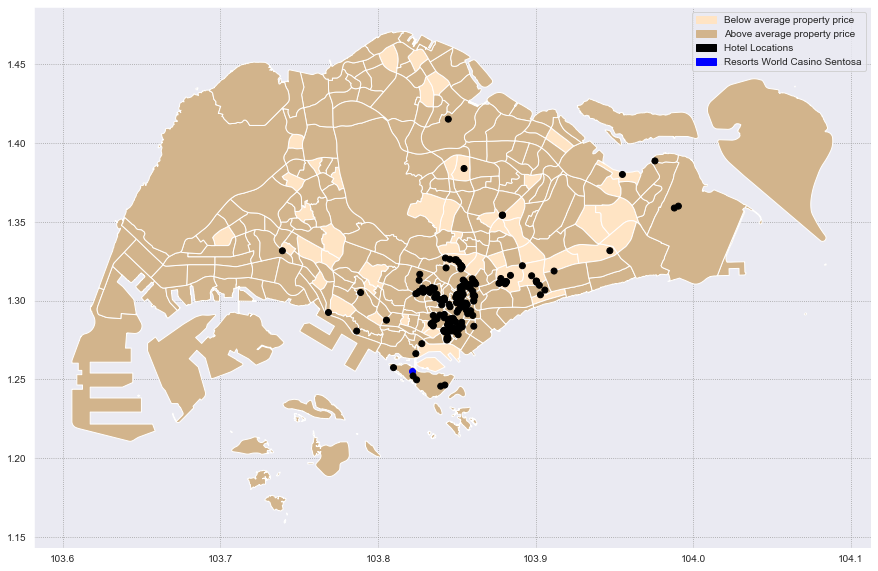

In [29]:
fig, ax = plt.subplots(figsize=(15,10))
below_average.plot(ax=ax, column="Average residential apartment price", color='bisque', label="Average residential apartment price")
above_average.plot(ax=ax, column="Average residential apartment price", color='tan', label="Average residential apartment price")
singapore_casino_locations.plot(ax=ax, column="casino_name", cmap=resorts_world_color, label="Resorts World Casino Sentosa")
singapore_hotels.plot(ax=ax, column="Name", cmap = hotels_color, label="Hotels")

below_avera_patch = mpatches.Patch(label='Below average property price', color='bisque')
above_avera_patch = mpatches.Patch(label='Above average property price', color='tan')
hotel_location_patch = mpatches.Patch(label='Hotel Locations', color='black')
casino_location_patch = mpatches.Patch(label='Resorts World Casino Sentosa', color='blue')

plt.legend(handles=[below_avera_patch, above_avera_patch, hotel_location_patch, casino_location_patch])

plt.axis()